# Pipeline de Dados do Telegram

Sérgio Lutzer

# 1. Introdução
Vivemos em uma era de transformação digital, onde os dados são o novo petróleo. As empresas que conseguem coletar, armazenar, processar e analisar os dados de forma eficiente e inteligente têm uma vantagem competitiva no mercado. Porém, lidar com os dados não é uma tarefa simples. Os dados são gerados em grande volume, variedade e velocidade, exigindo soluções robustas e escaláveis para o seu gerenciamento.

É aí que entra a computação em nuvem, que é a entrega de serviços de computação, armazenamento, rede, banco de dados, análise e outros pela internet, sem a necessidade de infraestrutura física própria. A computação em nuvem oferece benefícios como redução de custos, aumento de agilidade, flexibilidade, segurança e inovação. Além disso, a computação em nuvem permite a automatização de processos, que é a utilização de tecnologias para executar tarefas repetitivas, complexas ou demoradas, sem a intervenção humana. A automatização aumenta a produtividade, a qualidade, a eficiência e a confiabilidade dos processos.

A computação em nuvem e a automatização são fundamentais para a análise de dados, que é o processo de extrair informações, conhecimentos e insights dos dados, usando técnicas como estatística, matemática, inteligência artificial e visualização. A análise de dados permite às empresas tomar decisões baseadas em evidências, otimizar processos, entender o comportamento dos clientes, identificar oportunidades e riscos, entre outros.

Neste projeto, vamos explorar como construir uma pipeline de dados usando duas tecnologias poderosas e populares: a [Amazon Web Services](http://aws.amazon.com) (AWS) e o [Telegram](http://telegram.org).

## 1.1. AWS 
A **Amazon Web Service (AWS)** é a plataforma de nuvem mais adotada e mais abrangente do mundo, oferecendo mais de 200 serviços completos de datacenters em todo o mundo. Com a AWS, é possível reduzir custos, aumentar a agilidade e inovar mais rapidamente. A AWS oferece soluções para armazenamento, processamento, análise e visualização de dados, entre outras.

## 1.2. Telegram
O **Telegram** é um aplicativo de mensagens baseado em nuvem, que se destaca pela segurança e velocidade. O Telegram permite a criação de chatbots, que são ferramentas para conversar com os usuários em linguagem natural, por meio de diferentes plataformas digitais. Os chatbots podem ter diversas finalidades, como atendimento ao cliente, marketing e vendas. Além disso, os chatbots podem usar inteligência artificial para melhorar suas respostas e interações.

## 1.3. ChatBots
Os **chatbots do Telegram** geram uma grande quantidade de dados, que podem ser acessados por uma API. A API do Telegram fornece um token de acesso para cada chatbot, que permite a comunicação com o servidor. A documentação completa da API pode ser encontrada neste [link](https://core.telegram.org/bots/api).

## 1.4. Objetivo
Neste projeto, vamos mostrar como usar as ferramentas da **AWS** para coletar, armazenar, processar e analisar os dados gerados pelos **chatbots do Telegram**. Esses dados podem fornecer insights valiosos sobre o comportamento, as preferências e as necessidades dos usuários, bem como sobre o desempenho e a eficiência dos chatbots.

Este projeto faz parte das exigências para a conclusão do **curso Analista de Dados da EBAC**, uma escola online que oferece cursos de alta qualidade e relevância para o mercado de trabalho.

# 2. Arquitetura
O pipeline de dados consiste em três etapas principais: **Ingestão**, **ETL** e **Apresentação**.
- **Telegram**: *Fonte de dados transicionais* 
    - Os usuários interagem com um chatbot que é administrador de um grupo
    - O chatbot lê todas as mensagens enviadas pelos usuários e as envia para a AWS
- **AWS**: *a plataforma de nuvem para a pipeline de dados*
    - **Ingestão**: *o processo de capturar e armazenar os dados brutos*
        - O chatbot usa um webhook para enviar as mensagens para um endpoint do `AWS API Gateway`
        - O `AWS API Gateway` recebe as requisições **HTTP** com as mensagens no payload e as encaminha para o `AWS Lambda`
        - O `AWS Lambda` salva as mensagens em arquivos **JSON** no `AWS S3`, particionados por dia
    - **ETL**: *o processo de transformar e enriquecer os dados*
        - Diariamente, o `AWS Event Bridge` dispara o `AWS Lambda` para processar as mensagens do dia anterior
        - O `AWS Lambda` denormaliza os dados **JSON**, converte-os para o formato `Apache Parquet` e os armazena no `AWS S3`, particionados por dia
            - `Apache Parquet`: um formato de dados colunar que reduz o tamanho, o tempo e o custo do processamento de big data
            - `Comparação`: 1 TB em **CSV/JSON** equivale a 130 GB em **Parquet**, o que diminui a consulta de 236 para 6,78 segundos, uma melhora de 35 vezes com 13% do espaço (Fonte: [Alura](http://www.alura.com.br/artigos/arquivos-parquet)).
    - **Apresentação**: *o processo de disponibilizar e analisar os dados*
        - Uma tabela do `AWS Athena` é criada apontando para o bucket do `AWS S3` que contém os dados processados
        - A tabela pode ser consultada usando SQL para gerar insights sobre os usuários e os chatbots

A imagem abaixo mostra como cada etapa é realizada usando as ferramentas da AWS e do Telegram.
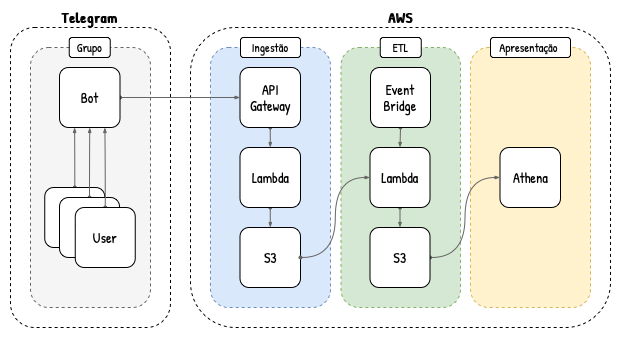

# 3. Telegram
No Telegram, as mensagens captadas por um bot podem ser acessadas por uma API única.

A única informação necessária é o `token` de acesso fornecido pelo `BotFather` na criação do bot. O token é gravado e aplicado através do método `getpass`.

In [3]:
from getpass import getpass

token = getpass()

 ··············································


A `url` é o ponto comum de todos os métodos da API

In [4]:
import json

import requests

base_url = f'https://api.telegram.org/bot{token}'

O método `getMe` retorna informações sobre o *bot*.

In [5]:
response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "id": 6296001258,
    "is_bot": true,
    "first_name": "lutzer_ebac_bot",
    "username": "lutzer_ebac_bot",
    "can_join_groups": false,
    "can_read_all_group_messages": false,
    "supports_inline_queries": false
  }
}


Finalmente, o método `getUpdates` retorna as mensagens captadas pelo *bot* enquanto o webhook não estiver ativo, após a ativação do webhook, o método `getUpdates` deixa de funcionar e retorna `"error_code": 409`.

In [6]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": false,
  "error_code": 409,
  "description": "Conflict: can't use getUpdates method while webhook is active; use deleteWebhook to delete the webhook first"
}


# 4. AWS
## 4.1. Ingestão
Para o processo de ingestão de dados, é necessário seguir os seguintes passos, que seguem a ordem inversa da ingestão descrito na arquitetura:
- Criar um bucket no `AWS S3`;
- Criar uma função no `AWS Lambda`;
- Criar uma API web no `AWS API Gateway`;
- Configurar o webhook da API de bots do Telegram.

### 4.1.1 Criar um bucket no `AWS S3`
O `AWS S3` é onde passivamente será armazenado as mensagens captadas pelo bot do Telegram no seu formato original: **JSON**. Para tanto, basta a criação de um bucket.
- *'bucket'* é o equivalente a *'pasta'* ou *'diretório'* para o `AWS S3`.

### 4.1.2. Criar uma função no`AWS Lambda`
o `AWS Lambda` tem a função de ativamente persistir as mensagens captadas pelo bot do **Telegram** em um bucket do `AWS S3`.

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

Nessa função `AWS_S3_BUCKET` e `TELEGRAM_CHAT_ID`, são [variáveis de ambiente](https://docs.aws.amazon.com/lambda/latest/dg/configuration-envvars.html), usadas para esconder informações sensíveis como IDs e senhas.
- `AWS_S3_BUCKET` corresponde ao `url` do bucket do `AWS S3`
-`TELEGRAM_CHAT_ID` corresponde à chave `["message"]["chat"]["id"]` do método `getUpdates` usado em `3. Telegram`.

Importante notar que as devidas permições devem ser dadas no `AWS IAM` para que o `AWS Lambda` possa acessar o devido bucket do `AWS S3`.

### 4.1.3. Criar uma API web no `AWS API Gateway`
O `AWS API Gateway` recebe as mensagens captadas pelo bot do Telegram, enviadas via webhook, e inicia uma função do `AWS Lambda`, passando o conteúdo da mensagem no seu parâmetro event.

Para tanto vamos criar uma API e configurá-la como gatilho da função do `AWS Lambda`:
- Acesse o serviço e selecione: *Create API* -> *REST API*;
- Insira um nome, como padrão, um que termine com o sufixo `-api`;
- Selecione: *Actions* -> *Create Method* -> *POST*;
- Na tela de *setup*:
    - Selecione *Integration type* igual a *Lambda Function*;
    - Habilite o *Use Lambda Proxy integration*;
    - Busque pelo nome a função do `AWS Lambda`.
  
Podemos testar a integração com o `AWS Lambda` através da ferramenta de testes do serviço. Por fim, vamos fazer a implantação da API e obter o seu endereço *web*.

- Selecione: *Actions* -> *Deploy API*;
- Selecione: *New Stage* para *Deployment stage*;
- Adicione *dev* como `Stage name`.

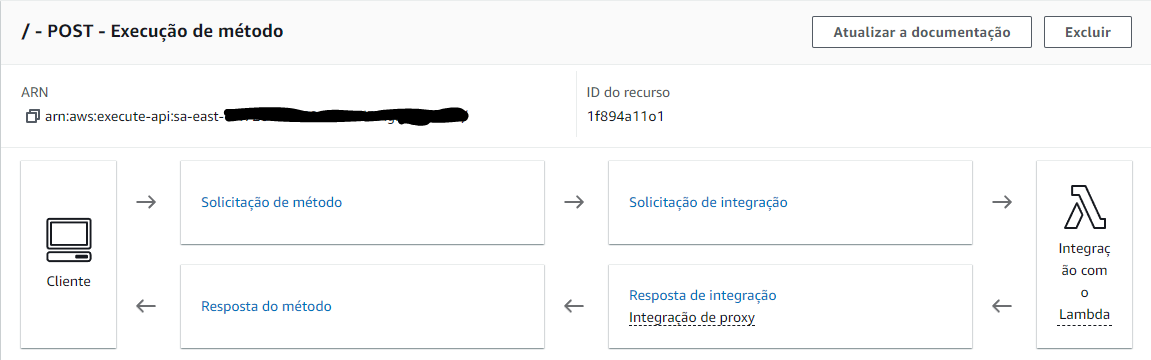)

Copie o a `url` gerada na variável `aws_api_gateway_url`.

In [7]:
aws_api_gateway_url = getpass()

 ··························································


### 4.1.4. Configurar o webhook da API de bots do Telegram
Para redirecionar as mensagens para a `url` do `AWS API Gateway`, utilizamos o método `setWebhook` para configurar o redirecionamento das mensagens captadas pelo *bot* para o endereço *web* do paramametro `url`.

In [8]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook is already set"
}


Já o método `getWebhookInfo` retorna as informações sobre o webhook configurado.

In [9]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://x7sd37igf0.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "18.229.23.39"
  }
}


## 4.2. ETL
A **extração, transformação e carregamento** (ETL) é uma etapa essencial para lidar com os dados que vêm de sistemas transacionais, isto é, que já estão armazenados em camadas raw de sistemas analíticos. Os processos realizados nesta etapa dependem muito do contexto da empresa, do tipo e da quantidade de dados consumidos, etc. Porém, em geral, o dado raw passa por um processo frequente de data wrangling, onde o dado é limpo, removido de duplicatas, etc. e armazenado com técnicas de particionamento, colunarização e compressão. Assim, o dado processado fica pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um dia, armazenadas na camada raw, serão compactadas em um único arquivo, colunar e comprimido, que será armazenado em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de data wrangling.

Para isso, vamos fazer passos muito semelhantes ao processo de Ingestão:
- Criar um bucket no `AWS S3` para a camada enriquecida;
- Usar uma função do `AWS Lambda` como motor de processamento;
- Para garantir a recorrência, vamos configurar uma regra do `AWS Event Bridge` como gatilho diário da função.

### 4.2.1. Criar um bucket no `AWS S3` para a camada enriquecida
Aqui o mesmo processo de `3.2.1` é repetido, porém com o sulfixo `-enriched`.

Na etapa de **ETL**, o `AWS S3` tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um *bucket*. Como padrão, vamos adicionar o sufixo `-enriched` ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

### 4.2.2. Usar uma função do `AWS Lambda` como motor de processamento

Na etapa de **ETL**, o `AWS Lambda` tem a função de ativamente processar as mensagens captadas pelo *bot* do **Telegram**, persistidas na camada cru no *bucket* do `AWS S3`, e persisti-las na camada enriquecida, também em um *bucket* do `AWS S3`. Logo, vamos criar uma função que opera da seguinte forma:
O objetivo dessa nova função, agora é:

- Lista todos os arquivos JSON de uma única participação da camada crua de um *bucket* do `AWS S3`;
- Para cada arquivo listado:
    - Faz o *download* do arquivo e carrega o conteúdo da mensagem;
    - Executa uma função de *data wrangling*;
    - Cria uma tabela do PyArrow e a contatena com as demais.
- Persiste a tabela no formato Parquet na camada enriquecida em um *bucket* do `AWS S3`.

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

Novamente, `AWS_S3_BUCKET` e `AWS_S3_ENRICHED` são variáveis de ambiente, onde:
- `AWS_S3_BUCKET` é a `url` do bucket inicial (raw)
- `AWS_S3_ENRICHED` é a `url` do bucket enriquecido.

Novamente, as devidas permições devem ser dadas no `AWS IAM` para que o `AWS Lambda` possa acessar o devido bucket do `AWS S3`.
________________________________________________________

Além dessa, outro código é adicionado para agir como *data wrangling*

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

O *timeout* padrão de funcões do `AWS Lambda` é de 3 segundos. Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (*input/output*) de arquivos do `AWS S3`.

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do AWS Lambda possui poucos pacotes externos instalado, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou layers, onde podemos fazer o upload dos pacotes Python direto na plataforma ou através de um bucket do AWS S3. Vamos então seguir com a última opção, onde teremos que:

 - Criar um *bucket* no `AWS S3`;
 - Fazer o *upload* do código do pacote Python do PyArrow (*download* neste [link](https://github.com/awslabs/aws-data-wrangler/releases));
 - Criar *layer* e conectar na função.

### 4.2.3. Configurar uma regra do `AWS Event Bridge` como gatilho diário da função.
Na etapa de **ETL**, o `AWS Event Bridge` tem a função de ativar diariamente a função de **ETL** do `AWS Lambda`, funcionando assim como um *scheduler* que levanta todas as mensagens do dia anterior.

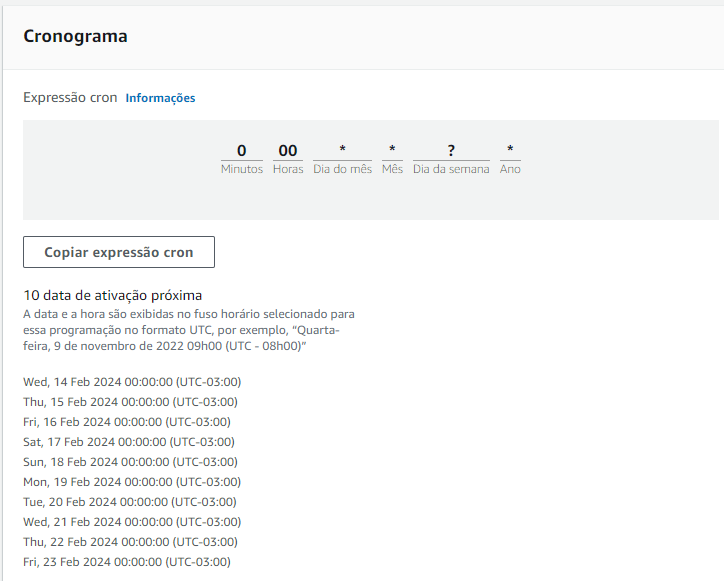

## 4.3. Apresentação
Na etapa de **apresentação**, o `AWS Athena` tem função de entregar o dados através de uma interface **SQL** para os usuários do sistema analítico. Para criar a interface, vamos criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

Nessa etapa, é necessário:
- Criar as tabelas particionadas diariamente
- Explorar os dados

### 4.3.1. Criar as tabelas

In [ ]:
```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint, 
  `user_id` bigint, 
  `user_is_bot` boolean, 
  `user_first_name` string, 
  `chat_id` bigint, 
  `chat_type` string, 
  `content` string, 
  `date` bigint)
PARTITIONED BY ( 
  `context_date` date)
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://modulo-44-telegram-enriched/telegram/'
```

### 4.3.2. Explorar os Dados (Consultas SQL)
Dentre as variadas possibilidades de ocnsultas sob as diferentes demandas de empresas, as mais comuns podem ser:

#### 4.3.2.1. Queries simples
- Quantidade de Mensagens por dia

```sql
SELECT 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY context_date 
ORDER BY context_date DESC
```

- Quantidade de mensagens que cada usuária manda por dia

```sql
SELECT 
  user_id, 
  user_first_name, 
  context_date, 
  count(1) AS "message_amount" 
FROM "telegram" 
GROUP BY 
  user_id, 
  user_first_name, 
  context_date 
ORDER BY context_date DESC
```

- Quantidade média de mensagens enviadas por cada usuário por mês.

```sql
SELECT 
  user_id, 
  user_first_name, 
  date_trunc('month', context_date) AS "month", 
  avg(message_amount) AS "monthly_average" 
FROM (
  SELECT 
    user_id, 
    user_first_name, 
    context_date, 
    count(1) AS "message_amount" 
  FROM "telegram" 
  GROUP BY 
    user_id, 
    user_first_name, 
    context_date
) AS subquery
GROUP BY 
  user_id, 
  user_first_name, 
  month 
ORDER BY month DESC
```

- Tamanho média de cada mensagem de cada usuário:

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

* Busca de um texto específico nas mensagens

```sql
SELECT user_first_name, text, context_date
FROM "telegram"
WHERE text LIKE '%{texto}'
```

#### 4.3.2.2 Queies mais robustas:

- Média de mensagens enviadas por cada usuário diariamente, por mês.

```sql
SELECT 
  user_id, 
  user_first_name, 
  date_trunc('month', context_date) AS "month", 
  avg(message_amount) AS "monthly_average" 
FROM (
  SELECT 
    user_id, 
    user_first_name, 
    context_date, 
    count(1) AS "message_amount" 
  FROM "telegram" 
  GROUP BY 
    user_id, 
    user_first_name, 
    context_date
) AS subquery
GROUP BY 
  user_id, 
  user_first_name, 
  month 
ORDER BY month DESC
```

- Média mensal de mensagens e tamanho delas:

```sql
SELECT 
  t1.user_id, 
  t1.user_first_name, 
  t1.month, 
  t1.monthly_average, 
  t2.average_message_length 
FROM (
  SELECT 
    user_id, 
    user_first_name, 
    date_trunc('month', context_date) AS "month", 
    avg(message_amount) AS "monthly_average" 
  FROM (
    SELECT 
      user_id, 
      user_first_name, 
      context_date, 
      count(1) AS "message_amount" 
    FROM "telegram" 
    GROUP BY 
      user_id, 
      user_first_name, 
      context_date
  ) AS subquery1
  GROUP BY 
    user_id, 
    user_first_name, 
    month 
) AS t1
JOIN (
  SELECT
    user_id,
    user_first_name,
    context_date,
    CAST(AVG(length(text)) AS INT) AS "average_message_length"
  FROM "telegram"
  GROUP BY
    user_id,
    user_first_name,
    context_date
) AS t2
ON t1.user_id = t2.user_id AND t1.context_date = t2.context_date
ORDER BY month DESC

```

- Quantidade de mensagens por hora por dia da semana por número da semana.

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

Todas as queries podem ser baixadas em csv e também podem ser linkadas com [Microsoft Power BI](https://aws.amazon.com/pt/blogs/aws-brasil/crie-dashboards-no-microsoft-power-bi-utilizando-o-conector-do-amazon-athena/) e [Google Data Studio](https://lookerstudio.google.com) para apresentação de Dashboards.

# 5. Conclusão
Neste projeto, aprendemos como construir uma pipeline de dados usando as ferramentas da AWS e do Telegram, para coletar, armazenar, processar e analisar as mensagens enviadas pelos usuários para um chatbot.

Este projeto nos mostrou os benefícios de usar os serviços da AWS e do Telegram para o ambiente de análise de dados e para as empresas que usam os chatbots do Telegram. Por exemplo, é possível:

Reduzir os custos das ferramentas, como podemos ver na imagem abaixo, que mostra o custo total do projeto na AWS:
image.png

* Aumentar a acessibilidade e a colaboração dos dados, pois trabalhando na nuvem os dados ficam disponíveis em qualquer lugar. Isso facilita o trabalho em equipe com engenheiros, cientistas e analistas de dados.
* Melhorar o desempenho das consultas, usando o formato parquet, que é um formato de dados colunar que reduz o tamanho, o tempo e o custo do processamento de big data.
* Integrar facilmente a API do Telegram com os serviços da AWS. Uma vez criada a API, ela funcionou corretamente e se manteve em funcionamento sem problemas.
* Gerar insights sobre os usuários e os chatbots, usando SQL para consultar os dados no AWS Athena. Além disso, é possível usar ferramentas como o AWS QuickSight ou o AWS Glue para criar gráficos e dashboards para visualizar as tendências, os padrões e as anomalias dos dados.
* Otimizar os chatbots, usando os insights gerados para melhorar as suas funcionalidades, personalizar as suas interações, aumentar o seu engajamento, etc.
* Este projeto faz parte das exigências para a conclusão do curso Analista de Dados da EBAC, uma escola online que oferece cursos de alta qualidade e relevância para o mercado de trabalho.

Ficamos satisfeitos com o resultado deste projeto e esperamos que você também tenha ficado. Agradecemos a sua atenção e o seu interesse.